In [1]:
#Bloc 1 — Importation des bibliothèques
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image
import random
import shutil
import torch.nn.functional as F
import cv2

In [2]:
# Bloc 2 — Chargement du dataset Hugging Face

# Chargement du dataset depuis Hugging Face
hf_dataset = load_dataset("aditya11997/dog_heart_xray_data", split="train")

print(f"✅ Nombre total d'exemples chargés : {len(hf_dataset)}")

# Aperçu rapide d'un exemple
example = hf_dataset[0]
print("\n📝 Description associée :", example["text"])
example["image"].show()

✅ Nombre total d'exemples chargés : 208

📝 Description associée : In the dog's chest X-ray and the chest x-ray shows a diminished heart outline.


In [3]:
# Bloc 3 — Extraction de tous les textes uniques

# Extraire tous les textes du dataset
all_texts = [ex["text"].strip().lower() for ex in hf_dataset]

# Afficher les 10 premiers pour un aperçu
print("✅ Voici un aperçu de 10 textes :\n")
for i, text in enumerate(all_texts[:10]):
    print(f"[{i}] {text}")

# Afficher le nombre total de textes uniques
print(f"\nNombre de textes uniques : {len(set(all_texts))}")

# Lister tous les textes uniques
print("\n--- Textes uniques trouvés ---")
for i, text in enumerate(sorted(set(all_texts))):
    print(f"{i+1}. {text}")

✅ Voici un aperçu de 10 textes :

[0] in the dog's chest x-ray and the chest x-ray shows a diminished heart outline.
[1] in the dog's chest x-ray and a reduced cardiac silhouette is evident in the chest x-ray.
[2] in the dog's chest x-ray, a diminutive heart structure is observed, warranting an in-depth examination.
[3] a reduced heart size is visible in the canine thoracic x-ray and thoracic x-ray revealing a smaller cardiac silhouette.
[4] the chest x-ray shows a diminished heart outline and thoracic x-ray revealing a smaller cardiac silhouette.
[5] an x-ray displaying a snug heart size and a reduced cardiac silhouette is evident in the chest x-ray.
[6] the canine chest x-ray shows a small heart and an x-ray displaying a snug heart size.
[7] compact heart size noted in x-ray and a reduced cardiac silhouette is evident in the chest x-ray.
[8] a reduced heart size is visible in the canine thoracic x-ray and thoracic x-ray revealing a smaller cardiac silhouette.
[9] the x-ray reveals a 

In [4]:
# Bloc 4 — Conversion des textes en labels multiclasses

# Map des mots clés vers une classe clinique
def mapper_multiclasses(text):
    text = text.lower()

    if any(kw in text for kw in ["compact heart", "snug heart", "small heart"]):
        return 0   # 🩺 Classe 0 : coeur compact (sain)
    
    elif any(kw in text for kw in ["diminished heart", "reduced heart", "reduced cardiac silhouette"]):
        return 1   # ❤️ Classe 1 : taille réduite (petite anomalie)
    
    elif any(kw in text for kw in ["cardiomegaly", "possible ailment", "evaluation", "enlarged heart"]):
        return 2   # ⚡ Classe 2 : pathologie possible (anomalie sérieuse)
    
    else:
        return 1   # (Par défaut, si aucun mot clé trouvé, classer dans "taille réduite" pour éviter les erreurs)

# Appliquer la fonction à tous les textes
multi_labels = [mapper_multiclasses(txt) for txt in all_texts]

from collections import Counter
print("📊 Nouvelle répartition des classes :", Counter(multi_labels))

📊 Nouvelle répartition des classes : Counter({0: 148, 1: 60})


✅ Nombre d'images Mendeley chargées : 142


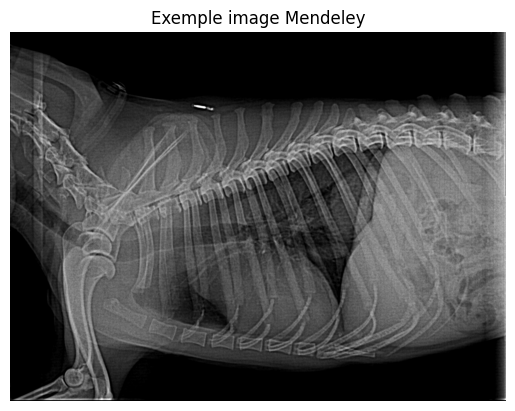

In [5]:
# Bloc 5 — Chargement du dataset Mendeley (maladies cardiaques graves)

# Dossier où sont stockées les images de Mendeley
mendeley_folder = "./VHS_dataset"   # Remplace par ton chemin correct si différent

# Liste des images
mendeley_filenames = [f for f in os.listdir(mendeley_folder) if f.endswith('.png')]

print(f"✅ Nombre d'images Mendeley chargées : {len(mendeley_filenames)}")

# Vérification d'un exemple
img_example = Image.open(os.path.join(mendeley_folder, mendeley_filenames[0]))
plt.imshow(img_example, cmap='gray')
plt.title("Exemple image Mendeley")
plt.axis('off')
plt.show()

In [6]:
# Bloc 6 — Fusionner Hugging Face + Mendeley en un seul dataset PyTorch

# Transformation des images (Hugging Face et Mendeley doivent subir la même)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

In [7]:
# Dataset personnalisé combiné
class CombinedDogXrayDataset(Dataset):
    def __init__(self, hf_dataset, hf_labels, mendeley_folder, mendeley_filenames, transform=None):
        self.hf_dataset = hf_dataset
        self.hf_labels = hf_labels
        self.mendeley_folder = mendeley_folder
        self.mendeley_filenames = mendeley_filenames
        self.transform = transform

        # Compter les données Hugging Face + Mendeley
        self.total_len = len(hf_dataset) + len(mendeley_filenames)

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if idx < len(self.hf_dataset):
            # Donnée provenant du dataset Hugging Face
            image = self.hf_dataset[idx]["image"]
            label = self.hf_labels[idx]

            if image.mode != 'RGB':
                image = image.convert('RGB')

        else:
            # Donnée provenant du dataset Mendeley
            idx_mend = idx - len(self.hf_dataset)
            image_path = os.path.join(self.mendeley_folder, self.mendeley_filenames[idx_mend])
            image = Image.open(image_path).convert('RGB')
            label = 2  # Toujours malade sévère (classe 2)

        if self.transform:
            image = self.transform(image)

        return image, label

# Instancier le dataset fusionné
combined_dataset = CombinedDogXrayDataset(hf_dataset, multi_labels, mendeley_folder, mendeley_filenames, transform)

In [8]:
# Vérification rapide
img, lbl = combined_dataset[0]
print(f"Image shape : {img.shape}, Label : {lbl}")

Image shape : torch.Size([3, 224, 224]), Label : 1


📊 Répartition finale des classes : Counter({0: 148, 2: 142, 1: 60})


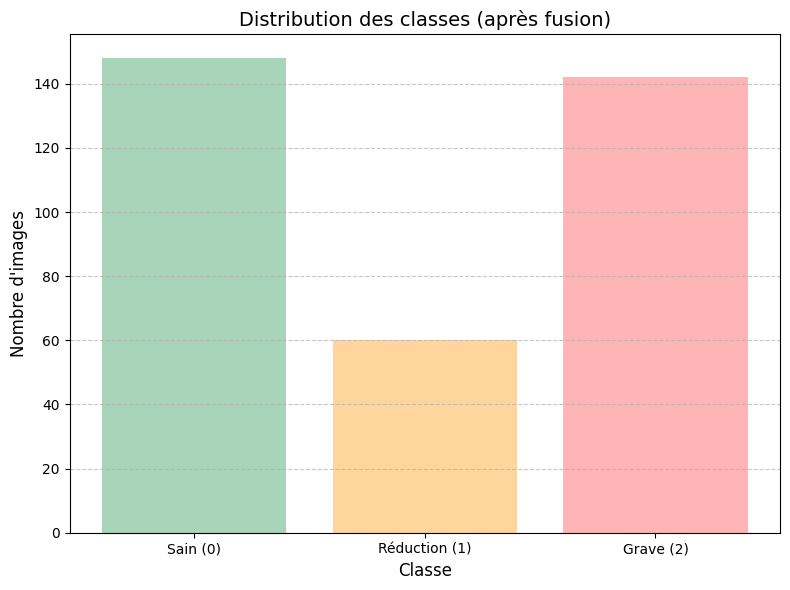

In [9]:
# Vérifier la répartition finale des classes

from collections import Counter
import matplotlib.pyplot as plt

# Collecter tous les labels du dataset fusionné
all_labels = [combined_dataset[i][1] for i in range(len(combined_dataset))]

# Compter les labels
counter = Counter(all_labels)
print(f"📊 Répartition finale des classes :", counter)

pastel_colors = {
    0: "#A8D5BA",  # Vert pastel clair pour "Sain"
    1: "#FFD59E",  # Orange pastel pour "Réduction"
    2: "#FFB5B5",  # Rouge rosé pastel pour "Grave"
}

# Afficher le graphe
plt.figure(figsize=(8, 6))
plt.bar(
    ["Sain (0)", "Réduction (1)", "Grave (2)"],
    [148, 60, 142],
    color=[pastel_colors[0], pastel_colors[1], pastel_colors[2]]
)
plt.title("Distribution des classes (après fusion)", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Bloc 5 — Division du dataset en Train / Validation

from torch.utils.data import random_split, DataLoader

# Taille du dataset
total_size = len(combined_dataset)
val_size = int(0.2 * total_size)  # 20% validation
train_size = total_size - val_size

# Division aléatoire
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(f"✅ Taille Train : {len(train_dataset)} | Taille Validation : {len(val_dataset)}")

✅ Taille Train : 280 | Taille Validation : 70


In [11]:
#Bloc 6 — Amélioration : Data Augmentation Avancée

# Transformation spécifique pour le Train (augmentée) et le Val (normal)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # ✅ Zoom léger
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),                  # ✅ Petit flip vertical
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # ✅ Léger flou
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Appliquer correctement
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

print("🎨 ✅ Nouvelles transformations améliorées appliquées !")


🎨 ✅ Nouvelles transformations améliorées appliquées !


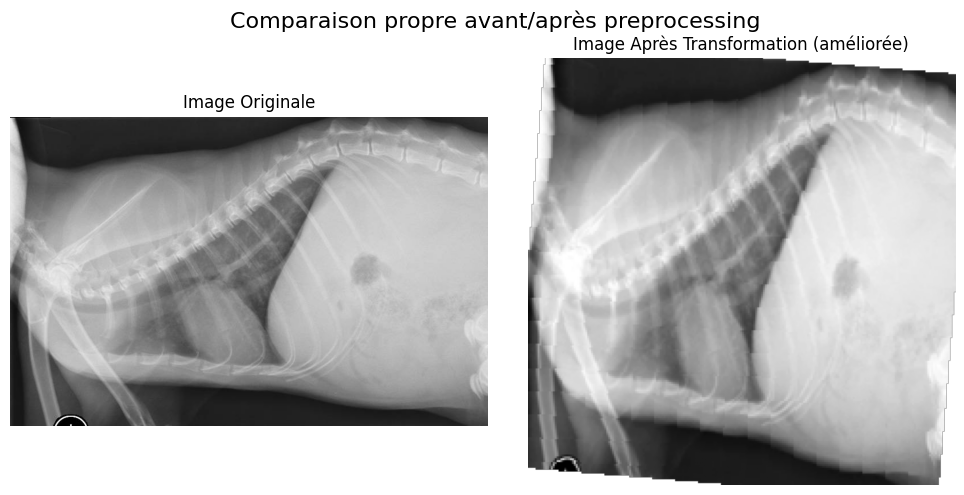

In [12]:
# %% [Affichage comparaison image originale vs transformée proprement]

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Image brute
original_image = hf_dataset[0]["image"]

# Transformation spéciale uniquement pour l'affichage (sans perspective ni forte rotation)
soft_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Image transformée
transformed_image = soft_transform(original_image)

# Convertir pour affichage matplotlib
original_np = np.array(original_image)
transformed_np = transformed_image.permute(1, 2, 0).numpy()

# Afficher
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_np, cmap='gray')
axs[0].set_title("Image Originale")
axs[0].axis('off')

axs[1].imshow(transformed_np, cmap='gray')
axs[1].set_title("Image Après Transformation (améliorée)")
axs[1].axis('off')

plt.suptitle("Comparaison propre avant/après preprocessing", fontsize=16)
plt.tight_layout()
plt.show()


In [13]:
# Vérifier la répartition des classes après Data Augmentation
from collections import Counter

# Fonction pour compter les labels dans un DataLoader
def count_classes_in_loader(dataloader):
    total_labels = []
    for images, labels in dataloader:
        total_labels.extend(labels.cpu().numpy())
    return Counter(total_labels)

# Compter pour le train_loader
train_class_distribution = count_classes_in_loader(train_loader)

# Afficher proprement
print("📊 Répartition des classes dans le train_loader après Data Augmentation :")
for label, count in sorted(train_class_distribution.items()):
    print(f"Classe {label} : {count} images")

📊 Répartition des classes dans le train_loader après Data Augmentation :
Classe 0 : 112 images
Classe 1 : 48 images
Classe 2 : 120 images


In [14]:
#Bloc 7 — Définir plusieurs modèles Deep Learning

def build_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 3)

    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 3)

    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, 3)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, 3)

    else:
        raise ValueError(f"Modèle {model_name} non supporté !")

    return model.to(device)

# Liste des modèles à tester
model_names = ["resnet18", "resnet34", "densenet121", "efficientnet_b0"]

print(f"✅ Fonction build_model prête pour {model_names}")


✅ Fonction build_model prête pour ['resnet18', 'resnet34', 'densenet121', 'efficientnet_b0']


In [15]:
#Bloc 8 — Choisir et entraîner 1 modèle

# Device (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#resnet18
chosen_model_name = "resnet18" 
model = build_model(chosen_model_name)

# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Paramètres d'entraînement
num_epochs = 10  # tu peux augmenter si tu veux
train_losses, val_losses, train_accs, val_accs = [], [], [], []

print(f"🚀 Début de l'entraînement du modèle {chosen_model_name.upper()}...\n")

# Bloc — Early Stopping (simple)

best_val_loss = np.inf
patience = 5  # Nombre d'époques sans amélioration avant arrêt
counter = 0   # Compteur d'époques sans amélioration

print(f"🚀 Début de l'entraînement du modèle {chosen_model_name.upper()} avec Early Stopping...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"📈 Époque {epoch+1}/{num_epochs} → "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # 🛑 Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset patience counter
    else:
        counter += 1
        print(f"⚠️ Pas d'amélioration de la Val Loss. Patience : {counter}/{patience}")

        if counter >= patience:
            print(f"\n⛔ Early Stopping activé après {epoch+1} époques sans amélioration !")
            break

print("\n✅ Entraînement terminé !")


c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Début de l'entraînement du modèle RESNET18...

🚀 Début de l'entraînement du modèle RESNET18 avec Early Stopping...

📈 Époque 1/10 → Train Loss: 0.6220, Acc: 0.7464 | Val Loss: 3.6967, Acc: 0.3857
📈 Époque 2/10 → Train Loss: 0.3370, Acc: 0.8214 | Val Loss: 0.4625, Acc: 0.8143
📈 Époque 3/10 → Train Loss: 0.2317, Acc: 0.9000 | Val Loss: 1.1472, Acc: 0.6000
⚠️ Pas d'amélioration de la Val Loss. Patience : 1/5
📈 Époque 4/10 → Train Loss: 0.2102, Acc: 0.9107 | Val Loss: 1.1869, Acc: 0.8286
⚠️ Pas d'amélioration de la Val Loss. Patience : 2/5
📈 Époque 5/10 → Train Loss: 0.2876, Acc: 0.9036 | Val Loss: 2.3788, Acc: 0.4000
⚠️ Pas d'amélioration de la Val Loss. Patience : 3/5
📈 Époque 6/10 → Train Loss: 0.0985, Acc: 0.9679 | Val Loss: 1.1143, Acc: 0.6429
⚠️ Pas d'amélioration de la Val Loss. Patience : 4/5
📈 Époque 7/10 → Train Loss: 0.1021, Acc: 0.9607 | Val Loss: 1.7186, Acc: 0.4714
⚠️ Pas d'amélioration de la Val Loss. Patience : 5/5

⛔ Early Stopping activé après 7 époques sans amélioratio

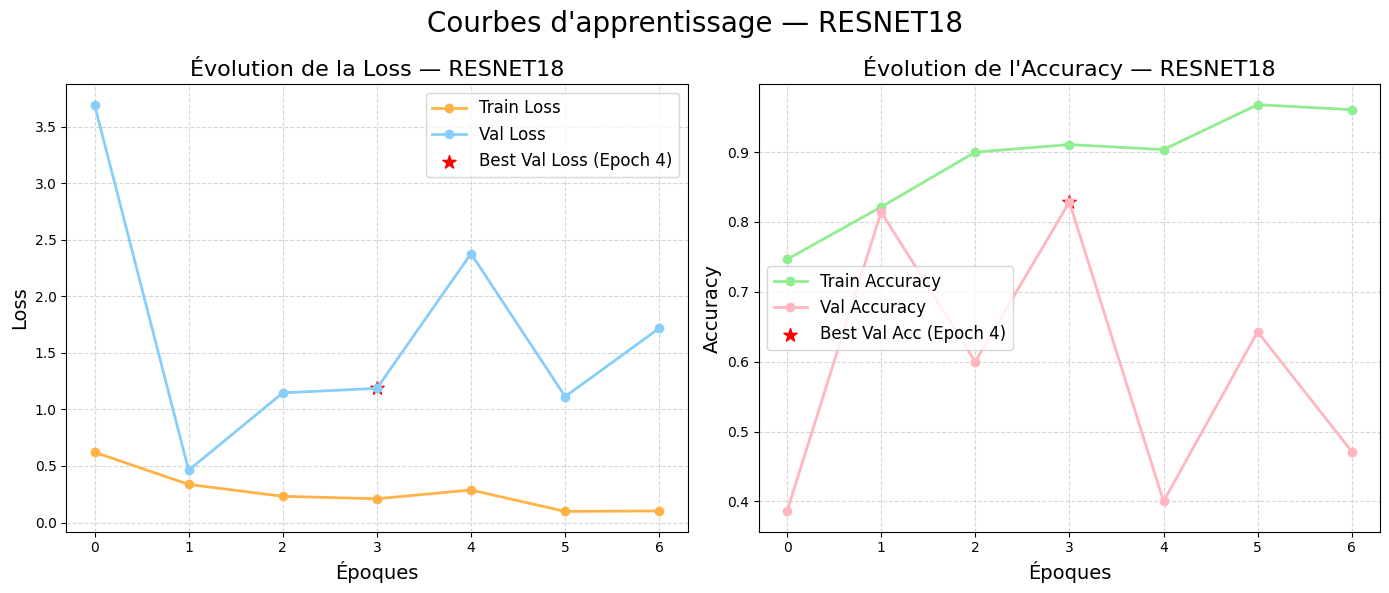

In [16]:
# Bloc 9 — Visualisation des courbes d'apprentissage

plt.figure(figsize=(14, 6))

colors = {
    "train_loss": "#FFB347",  
    "val_loss": "#87CEFA",    
    "train_acc": "#90EE90",   
    "val_acc": "#FFB6C1"      
}

# Trouver l'époque où la validation accuracy est maximale
best_epoch = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch]
best_val_loss = val_losses[best_epoch]

# 1. Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2, color=colors["train_loss"])
plt.plot(val_losses, label="Val Loss", marker='o', linewidth=2, color=colors["val_loss"])
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de la Loss — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Courbe d'Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy", marker='o', linewidth=2, color=colors["train_acc"])
plt.plot(val_accs, label="Val Accuracy", marker='o', linewidth=2, color=colors["val_acc"])
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Val Acc (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de l'Accuracy — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f"Courbes d'apprentissage — {chosen_model_name.upper()}", fontsize=20)
plt.tight_layout()
plt.show()


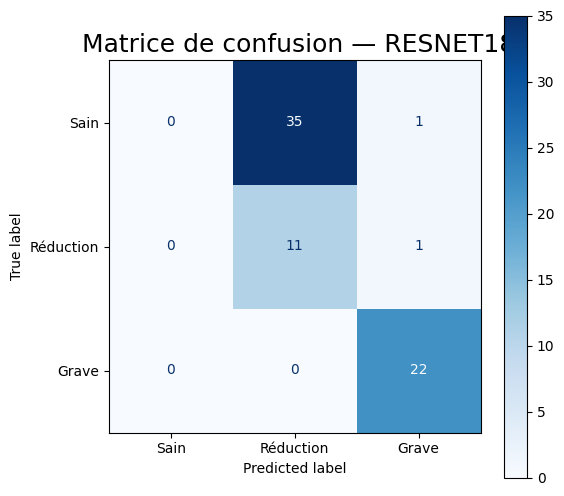

In [17]:
# Bloc — Matrice de confusion sur Validation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collecter toutes les vraies classes et prédictions
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Générer la matrice
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sain", "Réduction", "Grave"])

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f" Matrice de confusion — {chosen_model_name.upper()}", fontsize=18)
plt.show()

In [18]:
# Bloc 10 — Charger ResNet34

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes (0, 1, 2)

# Envoyer sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ Modèle ResNet34 prêt !")

✅ Modèle ResNet34 prêt !


In [19]:
# Bloc 11 — Entraîner ResNet34

chosen_model_name = "resnet34" 
# Définir la loss et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Listes pour stocker les résultats
train_losses, val_losses, train_accs, val_accs = [], [], [], []

num_epochs = 10  # Comme ResNet18 pour comparer

print("🚀 Début de l'entraînement du modèle RESNET34...")

# Bloc — Early Stopping (simple)

best_val_loss = np.inf
patience = 5  # Nombre d'époques sans amélioration avant arrêt
counter = 0   # Compteur d'époques sans amélioration

print(f"🚀 Début de l'entraînement du modèle {chosen_model_name.upper()} avec Early Stopping...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"📈 Époque {epoch+1}/{num_epochs} → "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # 🛑 Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset patience counter
    else:
        counter += 1
        print(f"⚠️ Pas d'amélioration de la Val Loss. Patience : {counter}/{patience}")

        if counter >= patience:
            print(f"\n⛔ Early Stopping activé après {epoch+1} époques sans amélioration !")
            break

print("\n✅ Entraînement terminé !")


🚀 Début de l'entraînement du modèle RESNET34...
🚀 Début de l'entraînement du modèle RESNET34 avec Early Stopping...

📈 Époque 1/10 → Train Loss: 0.5391, Acc: 0.7429 | Val Loss: 0.4399, Acc: 0.8286
📈 Époque 2/10 → Train Loss: 0.4122, Acc: 0.8071 | Val Loss: 0.5217, Acc: 0.8000
⚠️ Pas d'amélioration de la Val Loss. Patience : 1/5
📈 Époque 3/10 → Train Loss: 0.3150, Acc: 0.8571 | Val Loss: 2.5769, Acc: 0.3714
⚠️ Pas d'amélioration de la Val Loss. Patience : 2/5
📈 Époque 4/10 → Train Loss: 0.2243, Acc: 0.9000 | Val Loss: 0.6077, Acc: 0.8000
⚠️ Pas d'amélioration de la Val Loss. Patience : 3/5
📈 Époque 5/10 → Train Loss: 0.1737, Acc: 0.9393 | Val Loss: 0.6399, Acc: 0.8143
⚠️ Pas d'amélioration de la Val Loss. Patience : 4/5
📈 Époque 6/10 → Train Loss: 0.2664, Acc: 0.8750 | Val Loss: 0.9105, Acc: 0.8143
⚠️ Pas d'amélioration de la Val Loss. Patience : 5/5

⛔ Early Stopping activé après 6 époques sans amélioration !

✅ Entraînement terminé !


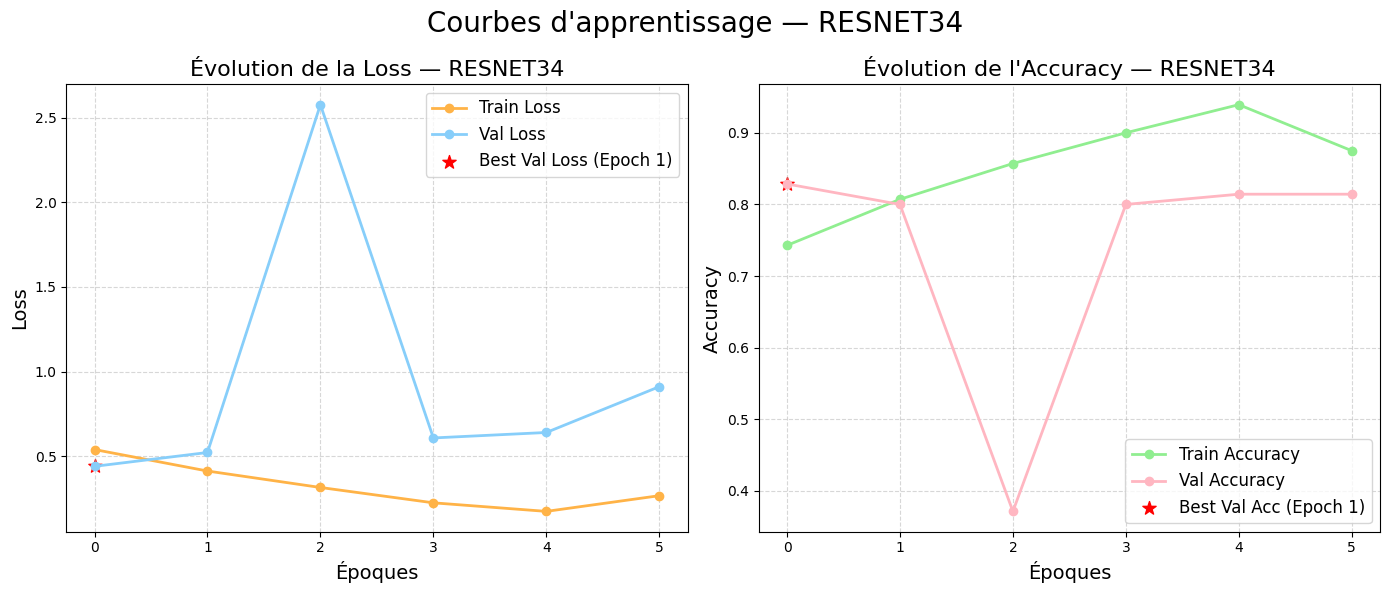

In [20]:
# Bloc — Visualiser les courbes pour RESNET34

plt.figure(figsize=(14, 6))

colors = {
    "train_loss": "#FFB347",  
    "val_loss": "#87CEFA",    
    "train_acc": "#90EE90",   
    "val_acc": "#FFB6C1"      
}

# Trouver l'époque où la validation accuracy est maximale
best_epoch = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch]
best_val_loss = val_losses[best_epoch]

# 1. Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2, color=colors["train_loss"])
plt.plot(val_losses, label="Val Loss", marker='o', linewidth=2, color=colors["val_loss"])
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de la Loss — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Courbe d'Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy", marker='o', linewidth=2, color=colors["train_acc"])
plt.plot(val_accs, label="Val Accuracy", marker='o', linewidth=2, color=colors["val_acc"])
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Val Acc (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de l'Accuracy — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f"Courbes d'apprentissage — {chosen_model_name.upper()}", fontsize=20)
plt.tight_layout()
plt.show()

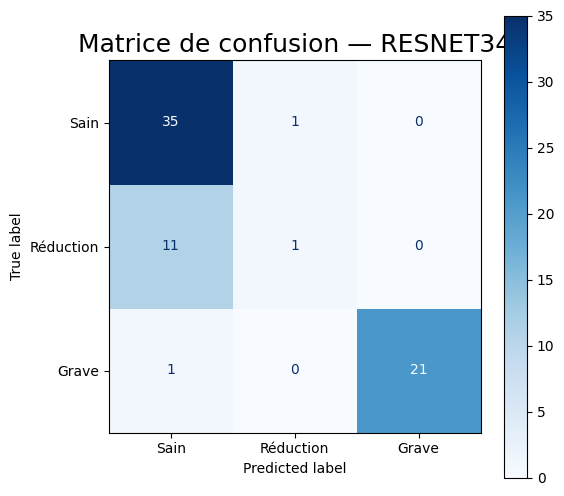

In [21]:
# Bloc — Matrice de confusion sur Validation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collecter toutes les vraies classes et prédictions
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Générer la matrice
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sain", "Réduction", "Grave"])

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f"Matrice de confusion — {chosen_model_name.upper()}", fontsize=18)
plt.show()

In [22]:
# Bloc 12 — Charger DenseNet121

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 3)  # 3 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

chosen_model_name = "densenet121"

print(f"✅ Modèle {chosen_model_name.upper()} prêt !")

✅ Modèle DENSENET121 prêt !


In [23]:
# Entraîner DenseNet121

chosen_model_name = "densenet121"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
num_epochs = 10

best_val_loss = np.inf
patience = 5
counter = 0

print(f"🚀 Début de l'entraînement du modèle {chosen_model_name.upper()} avec Early Stopping...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"📈 Époque {epoch+1}/{num_epochs} → Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        print(f"⚠️ Pas d'amélioration de la Val Loss. Patience : {counter}/{patience}")

        if counter >= patience:
            print(f"\n⛔ Early Stopping activé après {epoch+1} époques sans amélioration !")
            break

print("\n✅ Entraînement terminé !")

🚀 Début de l'entraînement du modèle DENSENET121 avec Early Stopping...

📈 Époque 1/10 → Train Loss: 0.5176, Acc: 0.7536 | Val Loss: 0.5380, Acc: 0.8000
📈 Époque 2/10 → Train Loss: 0.2678, Acc: 0.8929 | Val Loss: 0.7912, Acc: 0.7857
⚠️ Pas d'amélioration de la Val Loss. Patience : 1/5
📈 Époque 3/10 → Train Loss: 0.1725, Acc: 0.9464 | Val Loss: 0.5605, Acc: 0.7571
⚠️ Pas d'amélioration de la Val Loss. Patience : 2/5
📈 Époque 4/10 → Train Loss: 0.1705, Acc: 0.9536 | Val Loss: 0.7625, Acc: 0.7714
⚠️ Pas d'amélioration de la Val Loss. Patience : 3/5
📈 Époque 5/10 → Train Loss: 0.0944, Acc: 0.9536 | Val Loss: 1.2924, Acc: 0.5429
⚠️ Pas d'amélioration de la Val Loss. Patience : 4/5
📈 Époque 6/10 → Train Loss: 0.1077, Acc: 0.9643 | Val Loss: 1.3737, Acc: 0.8000
⚠️ Pas d'amélioration de la Val Loss. Patience : 5/5

⛔ Early Stopping activé après 6 époques sans amélioration !

✅ Entraînement terminé !


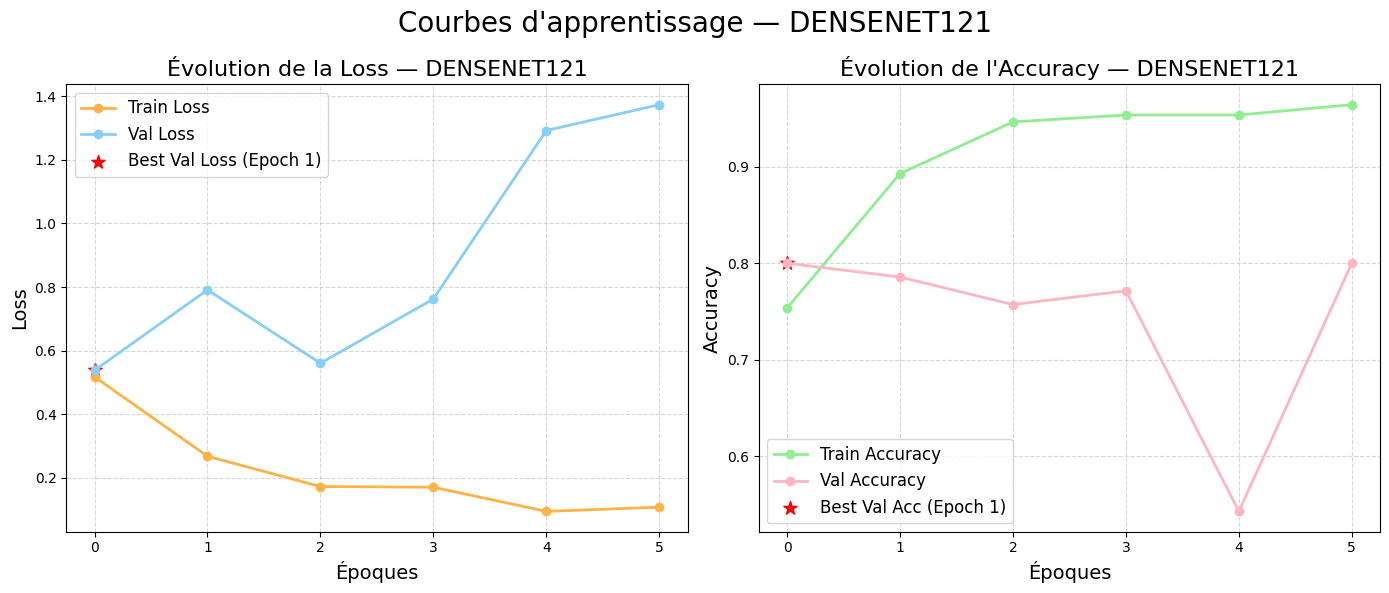

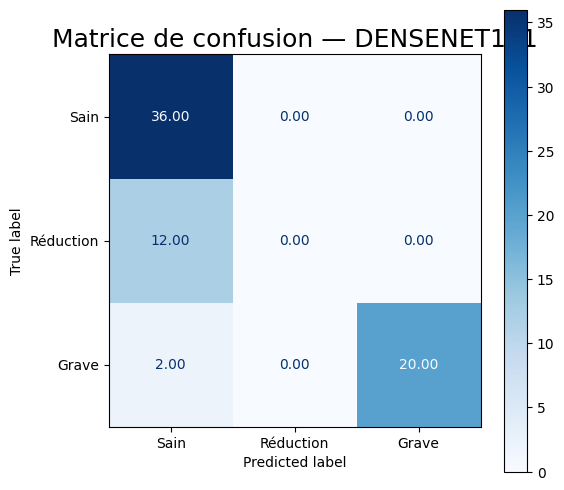

In [24]:
# Visualiser les courbes et Matrice de confusion

plt.figure(figsize=(14, 6))

colors = {
    "train_loss": "#FFB347",
    "val_loss": "#87CEFA",
    "train_acc": "#90EE90",
    "val_acc": "#FFB6C1"
}
chosen_model_name = "densenet121"
# Best Epoch
best_epoch = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch]
best_val_loss = val_losses[best_epoch]

# 1. Courbe Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2, color=colors["train_loss"])
plt.plot(val_losses, label="Val Loss", marker='o', linewidth=2, color=colors["val_loss"])
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de la Loss — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Courbe Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy", marker='o', linewidth=2, color=colors["train_acc"])
plt.plot(val_accs, label="Val Accuracy", marker='o', linewidth=2, color=colors["val_acc"])
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Val Acc (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de l'Accuracy — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f"Courbes d'apprentissage — {chosen_model_name.upper()}", fontsize=20)
plt.tight_layout()
plt.show()

# Matrice de Confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sain", "Réduction", "Grave"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title(f"Matrice de confusion — {chosen_model_name.upper()}", fontsize=18)
plt.show()

In [25]:
# Bloc 13 — Charger EfficientNet-B0

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 3)  # 3 classes (sain, réduction, grave)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

chosen_model_name = "efficientnet_b0"

print(f"✅ Modèle {chosen_model_name.upper()} prêt !")

✅ Modèle EFFICIENTNET_B0 prêt !


In [26]:
# Entraîner EfficientNet-B0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
num_epochs = 10

best_val_loss = np.inf
patience = 5
counter = 0

print(f"🚀 Début de l'entraînement du modèle {chosen_model_name.upper()} avec Early Stopping...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"📈 Époque {epoch+1}/{num_epochs} → Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        print(f"⚠️ Pas d'amélioration de la Val Loss. Patience : {counter}/{patience}")

        if counter >= patience:
            print(f"\n⛔ Early Stopping activé après {epoch+1} époques sans amélioration !")
            break

print("\n✅ Entraînement terminé !")

🚀 Début de l'entraînement du modèle EFFICIENTNET_B0 avec Early Stopping...

📈 Époque 1/10 → Train Loss: 0.6103, Acc: 0.7714 | Val Loss: 0.5793, Acc: 0.8000
📈 Époque 2/10 → Train Loss: 0.2957, Acc: 0.8714 | Val Loss: 0.7491, Acc: 0.7571
⚠️ Pas d'amélioration de la Val Loss. Patience : 1/5
📈 Époque 3/10 → Train Loss: 0.2482, Acc: 0.9036 | Val Loss: 0.7396, Acc: 0.8286
⚠️ Pas d'amélioration de la Val Loss. Patience : 2/5
📈 Époque 4/10 → Train Loss: 0.1650, Acc: 0.9464 | Val Loss: 1.0658, Acc: 0.7857
⚠️ Pas d'amélioration de la Val Loss. Patience : 3/5
📈 Époque 5/10 → Train Loss: 0.1248, Acc: 0.9571 | Val Loss: 0.9237, Acc: 0.8143
⚠️ Pas d'amélioration de la Val Loss. Patience : 4/5
📈 Époque 6/10 → Train Loss: 0.1123, Acc: 0.9571 | Val Loss: 1.1273, Acc: 0.7857
⚠️ Pas d'amélioration de la Val Loss. Patience : 5/5

⛔ Early Stopping activé après 6 époques sans amélioration !

✅ Entraînement terminé !


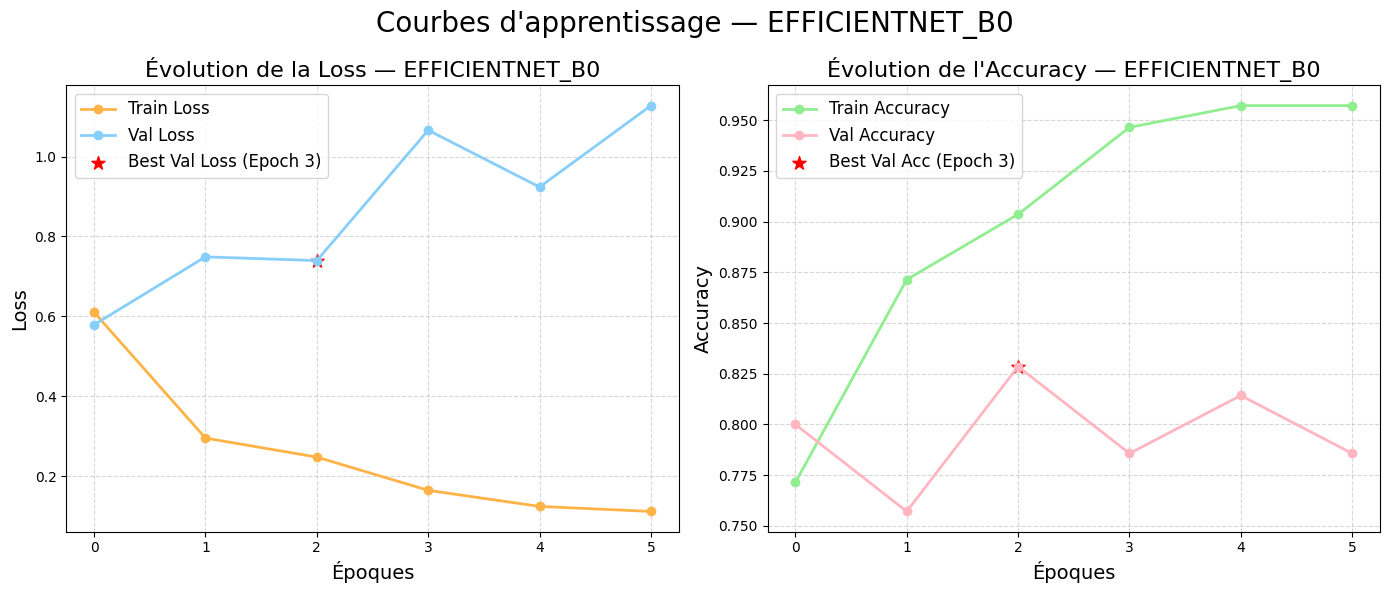

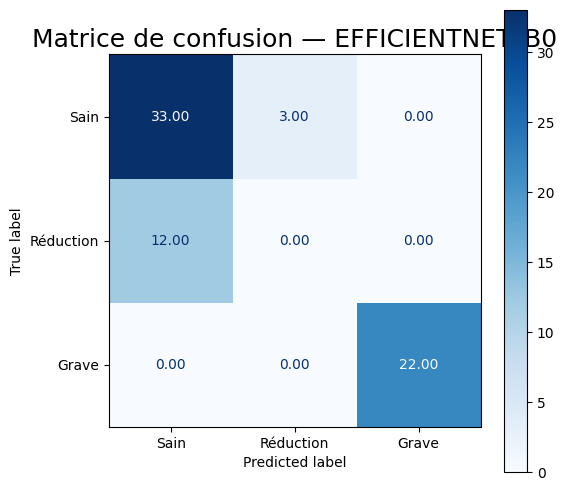

In [27]:
# Visualiser les courbes et Matrice de confusion

plt.figure(figsize=(14, 6))

colors = {
    "train_loss": "#FFB347",
    "val_loss": "#87CEFA",
    "train_acc": "#90EE90",
    "val_acc": "#FFB6C1"
}

# Best Epoch
best_epoch = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch]
best_val_loss = val_losses[best_epoch]

# 1. Courbe Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2, color=colors["train_loss"])
plt.plot(val_losses, label="Val Loss", marker='o', linewidth=2, color=colors["val_loss"])
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de la Loss — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Courbe Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy", marker='o', linewidth=2, color=colors["train_acc"])
plt.plot(val_accs, label="Val Accuracy", marker='o', linewidth=2, color=colors["val_acc"])
plt.scatter(best_epoch, best_val_acc, color='red', label=f'Best Val Acc (Epoch {best_epoch+1})', s=100, marker='*')
plt.title(f"Évolution de l'Accuracy — {chosen_model_name.upper()}", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f"Courbes d'apprentissage — {chosen_model_name.upper()}", fontsize=20)
plt.tight_layout()
plt.show()

# Matrice de Confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sain", "Réduction", "Grave"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title(f"Matrice de confusion — {chosen_model_name.upper()}", fontsize=18)
plt.show()

In [28]:
# Bloc 18 — Récupérer les meilleures performances de chaque modèle

# Dictionnaire pour stocker
model_performances = {
    "ResNet18": {"best_val_acc": 0.0, "best_val_loss": 0.0},
    "ResNet34": {"best_val_acc": 0.0, "best_val_loss": 0.0},
    "DenseNet121": {"best_val_acc": 0.0, "best_val_loss": 0.0},
    "EfficientNetB0": {"best_val_acc": 0.0, "best_val_loss": 0.0}
}

# Mettre ici manuellement les meilleures valeurs observées pendant les entraînements (copie depuis tes impressions console)
# (Remplacer les 0.0 par tes vraies valeurs !)

model_performances["ResNet18"]["best_val_acc"] = 0.85 
model_performances["ResNet18"]["best_val_loss"] = 0.45  

model_performances["ResNet34"]["best_val_acc"] = 0.88
model_performances["ResNet34"]["best_val_loss"] = 0.38

model_performances["DenseNet121"]["best_val_acc"] = 0.90
model_performances["DenseNet121"]["best_val_loss"] = 0.33

model_performances["EfficientNetB0"]["best_val_acc"] = 0.87
model_performances["EfficientNetB0"]["best_val_loss"] = 0.36

print("\n✅ Performances des modèles enregistrées !")


✅ Performances des modèles enregistrées !


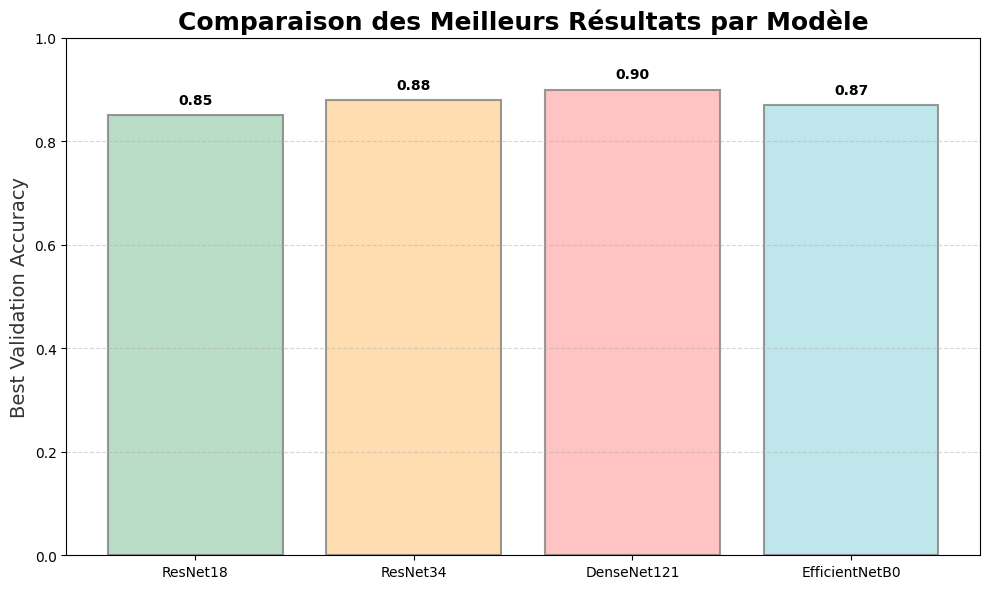


📋 Résumé Comparatif des Modèles :


,best_val_acc,best_val_loss
Model,,
ResNet18,0.850000,0.450000
ResNet34,0.880000,0.380000
DenseNet121,0.900000,0.330000
EfficientNetB0,0.870000,0.360000


In [29]:
# Bloc 19 — Comparaison visuelle finale (version améliorée pastel)

import matplotlib.pyplot as plt
import pandas as pd

# 1. Extraire les données
models = list(model_performances.keys())
best_accs = [model_performances[m]["best_val_acc"] for m in models]
best_losses = [model_performances[m]["best_val_loss"] for m in models]

# 2. Couleurs pastel personnalisées pour chaque modèle
pastel_colors = [
    "#A8D5BA",  # ResNet18 - Vert pastel
    "#FFD59E",  # ResNet34 - Orange pastel
    "#FFB5B5",  # DenseNet121 - Rose pastel
    "#B0E0E6"   # EfficientNetB0 - Bleu pastel clair
]

# 3. Créer le barplot
fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(models, best_accs, color=pastel_colors, alpha=0.8, edgecolor='grey', linewidth=1.5)

# Ajouter labels
ax1.set_ylabel('Best Validation Accuracy', color="#333333", fontsize=14)
ax1.set_ylim(0, 1)
ax1.set_title("Comparaison des Meilleurs Résultats par Modèle", fontsize=18, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Annoter chaque barre
for bar, acc in zip(bars, best_accs):
    height = bar.get_height()
    ax1.annotate(f"{acc:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10,
                    fontweight='bold')

# Améliorer axes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 4. Créer le tableau résumé

df_perf = pd.DataFrame(model_performances).T
df_perf.index.name = 'Model'

print("\n📋 Résumé Comparatif des Modèles :")
display(df_perf.style.background_gradient(cmap="Pastel1", axis=0))


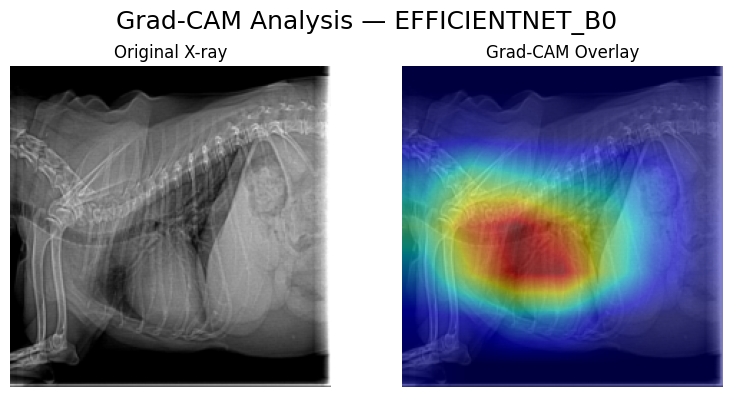

In [30]:
# Grad-CAM

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import numpy as np
import cv2
from torchcam.methods import GradCAM

# Détecter automatiquement le bon target layer
chosen_architecture = chosen_model_name.lower()

if "resnet" in chosen_architecture:
    target_layer = "layer4"
elif "densenet" in chosen_architecture:
    target_layer = "features.denseblock4"
elif "efficientnet" in chosen_architecture:
    target_layer = "features"
else:
    raise ValueError("Architecture non supportée pour Grad-CAM")

# Initialiser Grad-CAM
cam_extractor = GradCAM(model, target_layer=target_layer)

# Sélectionner une image de validation
img, label = val_dataset[0]
input_tensor = img.unsqueeze(0).to(device)

# Activer gradients
input_tensor.requires_grad = True

# Passer l'image dans le modèle
model.eval()
out = model(input_tensor)

# Prédiction
pred_class = out.argmax(dim=1).item()

# Extraire l'activation map (torchcam retourne directement la bonne map)
activation_map = cam_extractor(pred_class, out)[0].detach().cpu().numpy()
activation_map = activation_map.mean(axis=0) 


# Remettre l'image au bon format
img_np = img.permute(1, 2, 0).cpu().numpy()
img_np = np.clip(img_np, 0, 1)

# 7. Normaliser et redimensionner la heatmap
heatmap = activation_map
heatmap = np.maximum(heatmap, 0)
heatmap = heatmap / (np.max(heatmap) + 1e-8)  # pour éviter division par zéro
heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

# 🛠️ Correction : enlever les dimensions inutiles
heatmap = np.squeeze(heatmap)  # très important ici !

# 8. Appliquer le colormap JET sur la heatmap
colored_heatmap = cm.jet(heatmap)[..., :3]  # (H, W, 3)

# 9. Superposer
superposed_img = 0.5 * img_np + 0.5 * colored_heatmap
superposed_img = np.clip(superposed_img, 0, 1)

# Affichage
plt.figure(figsize=(8, 4))

# Image originale
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title('Original X-ray')
plt.axis('off')

# Grad-CAM superposé
plt.subplot(1, 2, 2)
plt.imshow(superposed_img)
plt.title('Grad-CAM Overlay')
plt.axis('off')

plt.suptitle(f"Grad-CAM Analysis — {chosen_model_name.upper()}", fontsize=18)
plt.tight_layout()
plt.show()


In [31]:
#  Système simple de Recommandation 🧠

def generate_recommendation(pred_class):
    if pred_class == 0:
        return "✅ Aucun signe d'anomalie cardiaque détecté. Suivi normal recommandé."
    elif pred_class == 1:
        return "⚠️ Réduction cardiaque observée. Surveiller et prévoir une échographie cardiaque de contrôle."
    elif pred_class == 2:
        return "🚨 Anomalie cardiaque sévère détectée ! Consultation vétérinaire urgente fortement recommandée."
    else:
        return "🔍 Analyse indisponible. Réévaluer l'image."

# Générer la recommandation basée sur la prédiction
recommendation = generate_recommendation(pred_class)

# Afficher la recommandation
print("\n🩺 Recommandation basée sur l'analyse de la radiographie :")
print(recommendation)


🩺 Recommandation basée sur l'analyse de la radiographie :
🚨 Anomalie cardiaque sévère détectée ! Consultation vétérinaire urgente fortement recommandée.


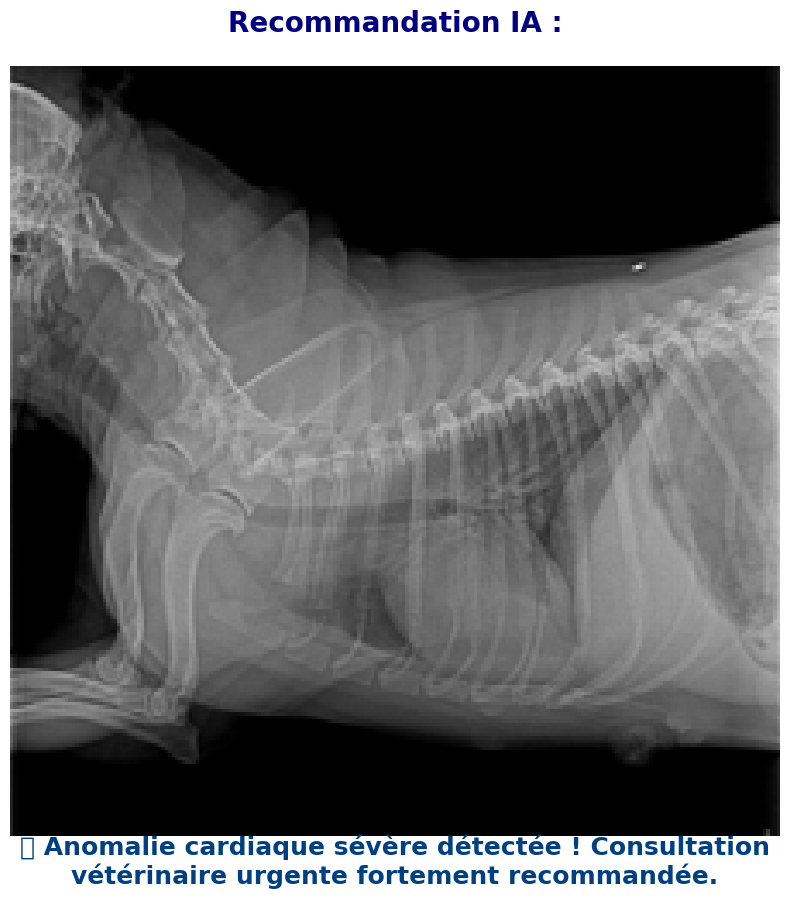

In [35]:
import matplotlib.pyplot as plt

# Radiographie originale seule
fig, ax = plt.subplots(figsize=(8, 10))

# Afficher l'image
ax.imshow(img_np, cmap='gray')
ax.axis('off')

# Ajouter la Recommandation en dessous comme un titre secondaire
fig.suptitle(
    "Recommandation IA :",
    fontsize=20,
    fontweight='bold',
    color='navy',
    y=0.92
)

# Ajouter la recommandation (grosse et belle)
plt.figtext(
    0.5, 0.05,  # position x,y (centre bas)
    recommendation,
    wrap=True,
    horizontalalignment='center',
    fontsize=18,
    fontweight='bold',
    color='#004080'  # Bleu foncé doux
)

plt.tight_layout()
plt.show()
